In [4]:
# 필요한 라이브러리 가져오기
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import optuna


# Set the random state for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# 데이터 로드 및 전처리
data_path = 'C:\\Users\\user\\Desktop\\PV\\실험\\전처리_v3\\Sejong_v3.csv'
data = pd.read_csv(data_path)
data['Date'] = pd.to_datetime(data['Date'])

# Normalize features except 'Date' and 'Solar_Power'
features = data.columns.drop(['Date', 'PVGeneration'])
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# 데이터 분할
train_data = data[data['Date'] < pd.to_datetime('2019-01-01 08:00:00')]
test_data = data[(data['Date'] >= pd.to_datetime('2019-01-01 08:00:00')) & (data['Date'] <= pd.to_datetime('2019-12-31 18:00:00'))]
val_size = int(0.1 * len(train_data))
train_df, val_df = torch.utils.data.random_split(train_data, [len(train_data) - val_size, val_size])

device = torch.device("cuda")

# 하이퍼파라미터 추가
hyperparameters = {
    'num_layers': 2,
    'hidden_size': 50,
    'output_size': 1,
    'num_epochs': 100,
    'window_size': 36,
    'batch_size': 64,
    'learning_rate': 0.001,
    'input_size': len(features),
    'forecast_horizon': 11
}


# TimeSeriesDataset 클래스
class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size, forecast_horizon):
        self.df = df.reset_index(drop=True)
        self.window_size = window_size
        self.forecast_horizon = forecast_horizon
        self.features = df.columns.drop(['Date', 'PVGeneration'])

    def __len__(self):
        return len(self.df) - self.window_size - self.forecast_horizon + 1

    def __getitem__(self, idx):
        x = self.df.loc[idx:idx + self.window_size - 1, self.features].values
        y = self.df.loc[idx + self.window_size:idx + self.window_size + self.forecast_horizon - 1, 'PVGeneration'].values
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# Train, Validation 데이터셋 생성 시 Subset 객체 대신 실제 데이터 프레임 사용
train_data_subset = train_data.iloc[train_df.indices].reset_index(drop=True)
val_data_subset = train_data.iloc[val_df.indices].reset_index(drop=True)

# Train, Validation, Test 데이터셋 생성
train_dataset = TimeSeriesDataset(train_data_subset, hyperparameters['window_size'], hyperparameters['forecast_horizon'])
val_dataset = TimeSeriesDataset(val_data_subset, hyperparameters['window_size'], hyperparameters['forecast_horizon'])
test_dataset = TimeSeriesDataset(test_data, hyperparameters['window_size'], hyperparameters['forecast_horizon'])

# 데이터 로더 정의
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)

# GRU Model Definition
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.3):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # num_layers가 1보다 클 때만 dropout을 적용
        if num_layers > 1:
            self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        else:
            self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Adjusted for forecast_horizon

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        # Adapted for multiple time step prediction
        out = self.fc(out[:, -1, :])  # Use the output of the last GRU layer
        return out


##########################################################################################################################################################################
# Define loss function
def nrmse(predictions, targets):
    rmse = sqrt(mean_squared_error(predictions, targets))
    return rmse / np.mean(targets)

def nmae(predictions, targets):
    mae_value = mean_absolute_error(predictions, targets)
    mean_target = np.mean(targets)
    nmae_value = mae_value / mean_target
    return nmae_value

def r2(predictions, targets):
    r2_value = r2_score(targets, predictions)
    return r2_value
##########################################################################################################################################################################
# Function to evaluate the model on the test set
def evaluate_model(model, test_loader, device, prediction_steps=11):
    model.eval()
    metrics_per_step = []

    with torch.no_grad():
        for step in range(prediction_steps):
            all_targets = []
            all_outputs = []
            for data, target in test_loader:
                data = data.to(device)
                output = model(data)  # output shape is [batch_size, forecast_horizon]
                output = output.view(-1, prediction_steps)  # reshaping to separate predictions
                target = target.view(-1)  # flatten target to match output's shape
                if step < target.size(0):  # check if there's enough data for this step
                    all_outputs.append(output[:, step].cpu().numpy())  # select prediction for the current step
                    all_targets.append(target.cpu().numpy())

            all_outputs = np.concatenate(all_outputs)
            all_targets = np.concatenate(all_targets)

            # Now ensure all_outputs and all_targets have the same length
            min_length = min(len(all_outputs), len(all_targets))
            all_outputs = all_outputs[:min_length]
            all_targets = all_targets[:min_length]

            avg_rmse = sqrt(mean_squared_error(all_targets, all_outputs))
            avg_nrmse = nrmse(np.array(all_outputs), np.array(all_targets))
            avg_nmae = nmae(np.array(all_outputs), np.array(all_targets))
            avg_r2 = r2(np.array(all_outputs), np.array(all_targets))

            metrics_per_step.append((avg_rmse, avg_nrmse, avg_nmae, avg_r2))
            print(f"Step {step+1}: RMSE: {avg_rmse}, NRMSE: {avg_nrmse}, NMAE: {avg_nmae}, R^2: {avg_r2}")

    # Calculate and return average metrics across all steps
    avg_rmse = np.mean([m[0] for m in metrics_per_step])
    avg_nrmse = np.mean([m[1] for m in metrics_per_step])
    avg_nmae = np.mean([m[2] for m in metrics_per_step])
    avg_r2 = np.mean([m[3] for m in metrics_per_step])
    print(f"Average: RMSE: {avg_rmse}, NRMSE: {avg_nrmse}, NMAE: {avg_nmae}, R^2: {avg_r2}")

    return avg_rmse, avg_nrmse, avg_nmae, avg_r2

# MSE 손실 함수 정의
mse_loss = nn.MSELoss()

# Optuna를 사용한 하이퍼파라미터 최적화
def objective(trial):
    input_size = hyperparameters['input_size']  # 입력 크기는 고정
    hidden_size = trial.suggest_int('hidden_size', 16, max(128, hyperparameters['hidden_size']))
    num_layers = trial.suggest_int('num_layers', 1, max(3, hyperparameters['num_layers']))
    learning_rate = trial.suggest_float('learning_rate', 1e-5, max(1e-1, hyperparameters['learning_rate']), log=True)  # 수정됨
    batch_size = trial.suggest_int('batch_size', 32, max(256, hyperparameters['batch_size']))

    model = GRUModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=hyperparameters['forecast_horizon']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(hyperparameters['num_epochs']):
        model.train()
        for seqs, labels in train_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(seqs).squeeze()  # .squeeze() 추가하여 차원 축소
            loss = mse_loss(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for seqs, labels in val_loader:
                seqs, labels = seqs.to(device), labels.to(device)
                outputs = model(seqs).squeeze()  # .squeeze() 추가하여 차원 축소
                loss = mse_loss(outputs, labels)
                val_loss += loss.item()

    return val_loss / len(val_loader)


# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 100)
best_params = study.best_trial.params

# 최적의 하이퍼파라미터를 사용하여 모델 생성
best_model = GRUModel(
    input_size=hyperparameters['input_size'],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    output_size=hyperparameters['forecast_horizon'],  # Add this line
    dropout_rate=0.3  # Assuming a fixed dropout rate, adjust if needed
).to(device)

# 최적의 하이퍼파라미터를 사용하여 옵티마이저 및 데이터 로더 설정
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)

# 모델 학습
for epoch in range(hyperparameters['num_epochs']):  # num_epochs를 사용하여 반복
    best_model.train()  # 모델을 학습 모드로 설정
    total_loss = 0
    for seqs, labels in train_loader:
        seqs, labels = seqs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = best_model(seqs).squeeze()  # 차원 축소
        loss = mse_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

# Test DataLoader 준비 - 수정된 부분
test_dataset = TimeSeriesDataset(test_data, hyperparameters['window_size'], hyperparameters['forecast_horizon'])  # forecast_horizon 추가
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)

# 모델 평가
avg_rmse, avg_nrmse, avg_nmae, avg_r2 = evaluate_model(best_model, test_loader, device)

[I 2024-03-12 11:35:31,067] A new study created in memory with name: no-name-c833cfc9-6838-4669-b034-070420dcabb2
[I 2024-03-12 11:38:08,138] Trial 0 finished with value: 0.07668512687087059 and parameters: {'hidden_size': 39, 'num_layers': 1, 'learning_rate': 0.0001807631284267219, 'batch_size': 215}. Best is trial 0 with value: 0.07668512687087059.
c:\Users\user\anaconda3\envs\min_hs_lstm2\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1, 11])) that is different to the input size (torch.Size([11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2024-03-12 11:45:27,360] Trial 1 finished with value: 0.12270263853398236 and parameters: {'hidden_size': 64, 'num_layers': 3, 'learning_rate': 0.001904028609547788, 'batch_size': 36}. Best is trial 0 with value: 0.07668512687087059.
[I 2024-03-12 11:48:29,558] Trial 2 finished 

Epoch 1, Loss: 0.224345909110431
Epoch 2, Loss: 0.21183532425041857
Epoch 3, Loss: 0.1997079674539895
Epoch 4, Loss: 0.18737907348007993
Epoch 5, Loss: 0.17440090970746402
Epoch 6, Loss: 0.1602810369483356
Epoch 7, Loss: 0.14469406676703486
Epoch 8, Loss: 0.12731851997046634
Epoch 9, Loss: 0.10856320606223469
Epoch 10, Loss: 0.09215696772624707
Epoch 11, Loss: 0.08425871000207703
Epoch 12, Loss: 0.08174301760977712
Epoch 13, Loss: 0.08062698640700044
Epoch 14, Loss: 0.08009321653637393
Epoch 15, Loss: 0.07979643190729208
Epoch 16, Loss: 0.07970352419491472
Epoch 17, Loss: 0.07956283359692015
Epoch 18, Loss: 0.07949406011351223
Epoch 19, Loss: 0.07941851405234172
Epoch 20, Loss: 0.07936607892143316
Epoch 21, Loss: 0.07930047116402922
Epoch 22, Loss: 0.07924423264018421
Epoch 23, Loss: 0.07920564813860531
Epoch 24, Loss: 0.07914188709752314
Epoch 25, Loss: 0.07911426856600005
Epoch 26, Loss: 0.07909875491569782
Epoch 27, Loss: 0.07909296735607345
Epoch 28, Loss: 0.07904960163708391
Epoch

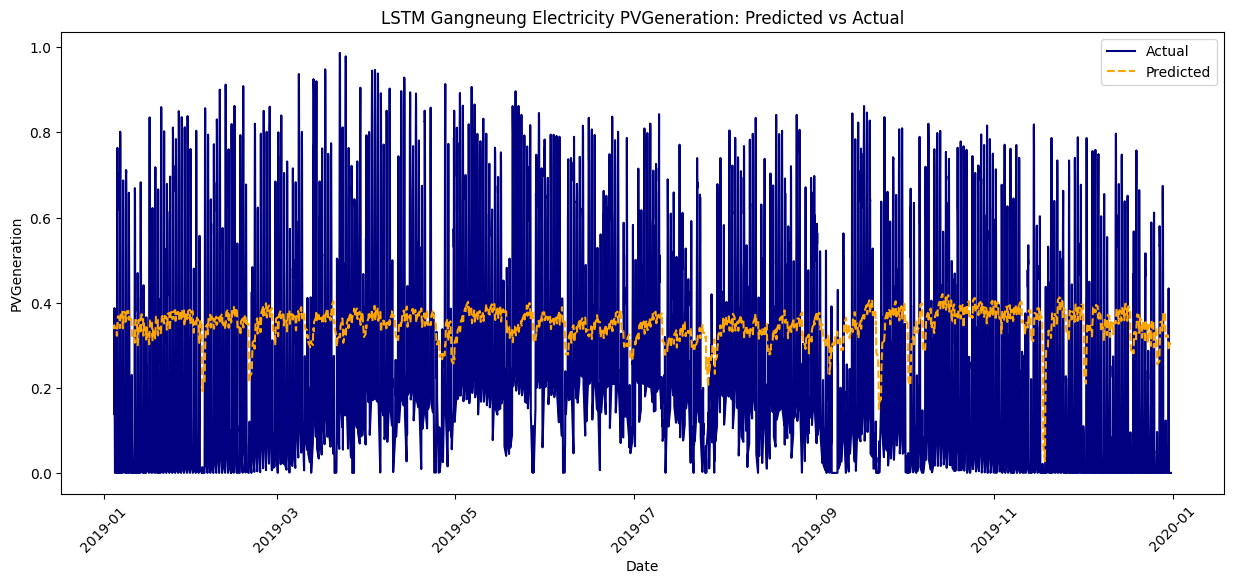

In [5]:
import matplotlib.pyplot as plt
import torch

# 모델을 평가 모드로 설정
best_model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        output = best_model(data)
        # output을 1차원 배열로 변환하여 predictions 리스트에 추가
        # 각 예측 시퀀스에 대한 첫 번째 예측값만 사용하되, 항상 1차원 배열로 처리
        pred = output[:, 0].detach().cpu().numpy()  # 1차원 배열을 유지
        # pred가 스칼라 값이면 리스트로 변환하여 extend
        predictions.extend(pred.flatten() if pred.ndim > 0 else [pred.item()])
        # 실제값 처리 시에도 동일한 방식 적용
        act = target[:, 0].cpu().numpy()
        actuals.extend(act.flatten() if act.ndim > 0 else [act.item()])

# 시간 데이터 추출 및 배열 길이 조정
dates = test_data['Date'].iloc[hyperparameters['window_size']:].values
# 예측값의 길이에 맞게 dates 배열 조정
dates = dates[:len(predictions)]

# 그래프 크기 설정
plt.figure(figsize=(15, 6))

# 실제값과 예측값을 그래프에 표시
plt.plot(dates, actuals, label='Actual', color='navy')
plt.plot(dates, predictions, label='Predicted', color='orange', linestyle='--')

# 그래프 제목과 레이블 설정
plt.title('LSTM Gangneung Electricity PVGeneration: Predicted vs Actual')
plt.xlabel('Date')
plt.ylabel('PVGeneration')
plt.xticks(rotation=45)
plt.legend()

# 그래프 표시
plt.show()


========================================================